In [ ]:
pip install pandas scikit-learn nltk bnlp

In [ ]:
pip install bnlp_toolkit

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bnlp import BasicTokenizer

# Load your dataset
data = pd.read_excel("dataset.xlsx")  # Replace with your file path

data['combined_text'] = data['category'] + ' ' + data['headline'] + ' ' + data['content']

# Preprocessing using bnlp
bnlp_tokenizer = BasicTokenizer()
data['combined_text'] = data['combined_text'].astype(str).apply(bnlp_tokenizer.tokenize)

# Convert content back to strings
data['combined_text'] = data['combined_text'].apply(lambda tokens: " ".join(tokens))

# Preprocessing
X = data['combined_text'].astype(str).values
y = data['label'].values

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a tokenizer
max_words = 10000
tokenizer = tf.keras.layers.TextVectorization(max_tokens=max_words, output_mode='int', output_sequence_length=200)
tokenizer.adapt(X_train)

# Tokenize and pad sequences
X_train_padded = tokenizer(X_train).numpy()
X_test_padded = tokenizer(X_test).numpy()

# Build LSTM models
def build_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=max_words, output_dim=100, input_length=200),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(256),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create three LSTM models
num_models = 5
models = [build_lstm_model() for _ in range(num_models)]

# Train each model
for i, model in enumerate(models):
    print(f"Training Model {i+1}")
    model.fit(X_train_padded, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Make predictions with each model
predictions = np.array([model.predict(X_test_padded) for model in models])

# Ensemble predictions using majority vote
ensemble_predictions = np.round(np.mean(predictions, axis=0)).flatten()

# Evaluate the ensemble
print(classification_report(y_test, ensemble_predictions))


punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Training Model 1
Epoch 1/100
237/237 [==============================] - 54s 181ms/step - loss: 0.7772 - accuracy: 0.5508 - val_loss: 1.0343 - val_accuracy: 0.5208
Epoch 2/100
237/237 [==============================] - 19s 80ms/step - loss: 0.6239 - accuracy: 0.6327 - val_loss: 1.0315 - val_accuracy: 0.5208
Epoch 3/100
237/237 [==============================] - 14s 59ms/step - loss: 0.4425 - accuracy: 0.7936 - val_loss: 1.6353 - val_accuracy: 0.5377
Epoch 4/100
237/237 [==============================] - 9s 38ms/step - loss: 0.2727 - accuracy: 0.8873 - val_loss: 1.5944 - val_accuracy: 0.5894
Epoch 5/100
237/237 [==============================] - 8s 33ms/step - loss: 0.1934 - accuracy: 0.9295 - val_loss: 15.0855 - val_accuracy: 0.4792
Epoch 6/100
237/237 [==============================] - 9s 36ms/step - loss: 0.1444 - accuracy: 0.9525 - val_loss: 2.0394 - val_accuracy: 0.5409
Epoch 7/100
237/237 [==============================] - 8s 33ms/step - loss: 0.1178 - accuracy: 0.9628 - val_loss: 

In [ ]:
accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy[1] * 100:.2f}%")

74/74 [==============================] - 1s 16ms/step - loss: 1.7861 - accuracy: 0.7867
Test Accuracy: 78.67%


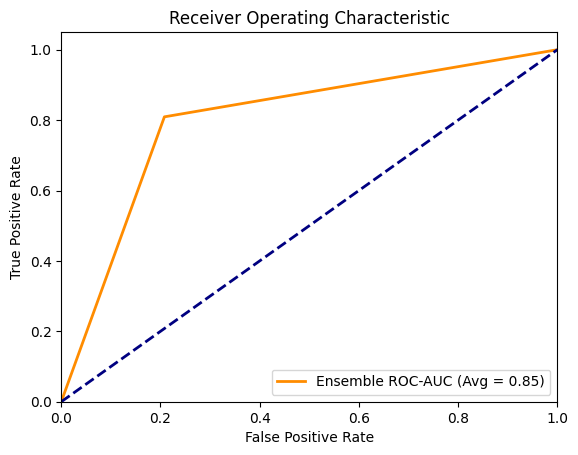

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
# Calculate ROC-AUC scores for each model
roc_auc_scores = [roc_auc_score(y_test, prediction) for prediction in predictions]

# Calculate average ROC-AUC score
avg_roc_auc = np.mean(roc_auc_scores)

# Compute the ROC curve and ROC-AUC for the ensemble predictions
fpr, tpr, _ = roc_curve(y_test, ensemble_predictions)
roc_auc = roc_auc_score(y_test, ensemble_predictions)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Ensemble ROC-AUC (Avg = {avg_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


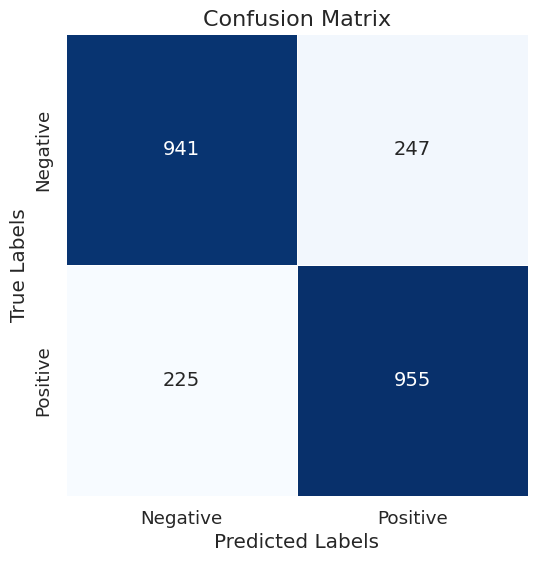

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, ensemble_predictions)

# Create a confusion matrix plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            annot_kws={"size": 14}, square=True, linewidths=0.5)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontsize=16)
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])
plt.show()


In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Load your dataset
data = pd.read_excel("dataset.xlsx")

# Define preprocessing functions
def preprocess_text(text):
    # Removing punctuations, English letters, and digits
    cleaned_text = re.sub(r'[^\u0980-\u09FF\s]', '', text)
    # Lowercasing the text
    cleaned_text = cleaned_text.lower()
    # Removing multiple spaces
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

def tokenize_and_stem(text):
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

# Apply preprocessing to each row
data['headline_cleaned'] = data['headline'].apply(preprocess_text)

def preprocess_content(text):
    if isinstance(text, str):
        return preprocess_text(text)
    return ''

data['content_cleaned'] = data['content'].apply(preprocess_content)

# Tokenize and stem the cleaned text
data['headline_processed'] = data['headline_cleaned'].apply(tokenize_and_stem)

def tokenize_and_stem_content(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        stemmer = PorterStemmer()
        stemmed_tokens = [stemmer.stem(token) for token in tokens]
        return stemmed_tokens
    return []

data['content_processed'] = data['content_cleaned'].apply(tokenize_and_stem_content)

# Remove Bangla stop words
nltk.download('stopwords')
stop_words = set(stopwords.words("bengali"))
data['headline_final'] = data['headline_processed'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
data['content_final'] = data['content_processed'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

# Combine headline and content tokens for input features
data['combined_tokens'] = data.apply(lambda row: row['headline_final'] + row['content_final'], axis=1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['combined_tokens'], data['label'], test_size=0.2, random_state=42)

# Convert tokenized text to string for TF-IDF vectorization
X_train_strings = X_train.apply(lambda tokens: ' '.join(tokens))
X_test_strings = X_test.apply(lambda tokens: ' '.join(tokens))

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train_strings)
X_test_tfidf = vectorizer.transform(X_test_strings)

# Train a fake news detection model (Naive Bayes classifier)
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[[693 495]
 [231 949]]
              precision    recall  f1-score   support

           0       0.75      0.58      0.66      1188
           1       0.66      0.80      0.72      1180

    accuracy                           0.69      2368
   macro avg       0.70      0.69      0.69      2368
weighted avg       0.70      0.69      0.69      2368



In [ ]:
from sklearn.metrics import accuracy_score

# ... (Preprocessing and model training code)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.69


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset
data = pd.read_excel("dataset.xlsx")  # Replace with your dataset file

# Preprocessing: Sentencepiece Tokenization
from bnlp import SentencepieceTokenizer
bsp = SentencepieceTokenizer()

# Replace missing values in 'content' column with an empty string
data['content'].fillna('', inplace=True)

data['headline_tokens'] = data['headline'].apply(bsp.tokenize)
data['content_tokens'] = data['content'].apply(bsp.tokenize)

# Preprocessing: Basic Tokenization
from bnlp import BasicTokenizer
tokenizer = BasicTokenizer()
data['headline_basic_tokens'] = data['headline'].apply(tokenizer.tokenize)
data['content_basic_tokens'] = data['content'].apply(tokenizer.tokenize)

# Preprocessing: NLTK Tokenization
from bnlp import NLTKTokenizer
bnltk = NLTKTokenizer()
data['headline_word_tokens'] = data['headline'].apply(bnltk.word_tokenize)
data['content_sentence_tokens'] = data['content'].apply(bnltk.sentence_tokenize)



# ... (Other preprocessing steps you've provided)

# Combine cleaned headline and content tokens for input features
# Combine cleaned headline and content tokens for input features
data['combined_tokens1'] = data.apply(lambda row: ' '.join(row['headline_tokens'] + row['content_tokens']), axis=1)
data['combined_tokens2'] = data.apply(lambda row: ' '.join(row['headline_basic_tokens'] + row['content_basic_tokens']), axis=1)
data['combined_tokens3'] = data.apply(lambda row: ' '.join(row['headline_word_tokens'] + row['content_sentence_tokens']), axis=1)


# Rest of the code remains unchanged



In [ ]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['combined_tokens1'], data['label'], test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a fake news detection model (Naive Bayes classifier)
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.79      0.63      0.70      1188
           1       0.69      0.83      0.76      1180

    accuracy                           0.73      2368
   macro avg       0.74      0.73      0.73      2368
weighted avg       0.74      0.73      0.73      2368



In [ ]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['combined_tokens2'], data['label'], test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a fake news detection model (Naive Bayes classifier)
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1188
           1       0.69      0.82      0.75      1180

    accuracy                           0.73      2368
   macro avg       0.73      0.73      0.72      2368
weighted avg       0.73      0.73      0.72      2368



In [ ]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['combined_tokens3'], data['label'], test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a fake news detection model (Naive Bayes classifier)
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))


Accuracy: 0.73
              precision    recall  f1-score   support

           0       0.78      0.63      0.70      1188
           1       0.69      0.82      0.75      1180

    accuracy                           0.73      2368
   macro avg       0.73      0.73      0.72      2368
weighted avg       0.73      0.73      0.72      2368



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from bnlp import SentencepieceTokenizer
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC

# Download stopwords list if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset (replace with your dataset file)
data = pd.read_excel("dataset.xlsx")

# Preprocessing: Sentencepiece Tokenization
bsp = SentencepieceTokenizer()
data['content'].fillna('', inplace=True)

data['headline_tokens'] = data['headline'].apply(bsp.tokenize)
data['content_tokens'] = data['content'].apply(bsp.tokenize)

# Remove stopwords using NLTK
stop_words = set(stopwords.words("bengali"))
data['headline_tokens'] = data['headline_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
data['content_tokens'] = data['content_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Combine cleaned headline and content tokens for input features
data['combined_tokens'] = data.apply(lambda row: row['headline_tokens'] + row['content_tokens'], axis=1)

# Prepare features and labels
X = data['combined_tokens']
y = data['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train.apply(lambda tokens: ' '.join(tokens)))
X_test_tfidf = vectorizer.transform(X_test.apply(lambda tokens: ' '.join(tokens)))

# Train a fake news detection model (Naive Bayes classifier)
model = SVC()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Accuracy: 0.80
              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1188
           1       0.77      0.84      0.81      1180

    accuracy                           0.80      2368
   macro avg       0.80      0.80      0.80      2368
weighted avg       0.80      0.80      0.80      2368



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from bnlp import SentencepieceTokenizer
import nltk
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier


# Download stopwords list if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset (replace with your dataset file)
data = pd.read_excel("dataset.xlsx")

# Preprocessing: Sentencepiece Tokenization
bsp = SentencepieceTokenizer()
data['content'].fillna('', inplace=True)

data['headline_tokens'] = data['headline'].apply(bsp.tokenize)
data['content_tokens'] = data['content'].apply(bsp.tokenize)

# Remove stopwords using NLTK
stop_words = set(stopwords.words("bengali"))
data['headline_tokens'] = data['headline_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
data['content_tokens'] = data['content_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Combine cleaned headline and content tokens for input features
data['combined_tokens'] = data.apply(lambda row: row['headline_tokens'] + row['content_tokens'], axis=1)

# Prepare features and labels
X = data['combined_tokens']
y = data['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train.apply(lambda tokens: ' '.join(tokens)))
X_test_tfidf = vectorizer.transform(X_test.apply(lambda tokens: ' '.join(tokens)))

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
extra_model = ExtraTreesClassifier(n_estimators=100, random_state=42)

# Create a VotingClassifier
voting_classifier = VotingClassifier(
    estimators=[('random_forest', rf_model), ('gradient_boosting', gb_model),
                ('ada_boost', ada_model), ('extra_trees', extra_model)],
    voting='soft'  # You can choose 'hard' or 'soft' voting
)

# Fit the VotingClassifier
voting_classifier.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = voting_classifier.predict(X_test_tfidf)

# Print classification report
print(classification_report(y_test, y_pred))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1188
           1       0.78      0.86      0.82      1180

    accuracy                           0.81      2368
   macro avg       0.82      0.81      0.81      2368
weighted avg       0.82      0.81      0.81      2368



In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.81


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from sklearn.metrics import accuracy_score
from bnlp import SentencepieceTokenizer
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping

# Download stopwords list if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset (replace with your dataset file)
data = pd.read_excel("dataset.xlsx")

# Preprocessing: Sentencepiece Tokenization
bsp = SentencepieceTokenizer()
data['content'].fillna('', inplace=True)

data['headline_tokens'] = data['headline'].apply(bsp.tokenize)
data['content_tokens'] = data['content'].apply(bsp.tokenize)

# Remove stopwords using NLTK
stop_words = set(stopwords.words("bengali"))
data['headline_tokens'] = data['headline_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
data['content_tokens'] = data['content_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Combine cleaned headline and content tokens for input features
data['combined_tokens'] = data.apply(lambda row: row['headline_tokens'] + row['content_tokens'], axis=1)

# Prepare features and labels
X = data['combined_tokens']
y = data['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_length = 200  # Adjust as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train CNN-LSTM model
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64,
                    validation_split=0.2, callbacks=[early_stopping])

# Evaluate model
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 200, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 64)           0         
 )                                                               
                                                                 
 lstm_22 (LSTM)              (None, 128)               98816     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                      

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from bnlp import SentencepieceTokenizer
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping

# Download stopwords list if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset (replace with your dataset file)
data = pd.read_excel("dataset.xlsx")

# Preprocessing: Sentencepiece Tokenization
bsp = SentencepieceTokenizer()
data['content'].fillna('', inplace=True)

data['headline_tokens'] = data['headline'].apply(bsp.tokenize)
data['content_tokens'] = data['content'].apply(bsp.tokenize)

# Remove stopwords using NLTK
stop_words = set(stopwords.words("bengali"))
data['headline_tokens'] = data['headline_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])
data['content_tokens'] = data['content_tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])

# Combine cleaned headline and content tokens for input features
data['combined_tokens'] = data.apply(lambda row: row['headline_tokens'] + row['content_tokens'], axis=1)

# Prepare features and labels
X = data['combined_tokens']
y = data['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_length = 200  # Adjust as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_length))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train CNN-LSTM model
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=64,
                    validation_split=0.2) #, callbacks=[early_stopping]

# Evaluate model
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 200, 128)          640000    
                                                                 
 conv1d_1 (Conv1D)           (None, 198, 128)          49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 99, 128)          0         
 1D)                                                             
                                                                 
 lstm_23 (LSTM)              (None, 99, 128)           131584    
                                                                 
 lstm_24 (LSTM)              (None, 64)                49408     
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                     

In [ ]:
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      1188
           1       0.78      0.78      0.78      1180

    accuracy                           0.78      2368
   macro avg       0.78      0.78      0.78      2368
weighted avg       0.78      0.78      0.78      2368



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from bnlp import SentencepieceTokenizer
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping

# Download stopwords list if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load your dataset (replace with your dataset file)
data = pd.read_excel("dataset.xlsx")

# Preprocessing: Sentencepiece Tokenization
bsp = SentencepieceTokenizer()
data['content'].fillna('', inplace=True)

data['headline_tokens'] = data['headline'].apply(bsp.tokenize)
data['content_tokens'] = data['content'].apply(bsp.tokenize)

# Combine headline and content for more context
data['combined_text'] = data['headline_tokens'] + data['content_tokens']

# Combine tokens into sentences
data['sentences'] = data['combined_text'].apply(lambda tokens: ' '.join(tokens))

# Remove stopwords using NLTK
stop_words = set(stopwords.words("bengali"))
data['cleaned_sentences'] = data['sentences'].apply(lambda sentence: ' '.join([word for word in sentence.split() if word not in stop_words]))

# Prepare features and labels
X = data['cleaned_sentences']
y = data['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
max_length = 200  # Adjust as needed
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

# Create an ensemble of three models
num_models = 3
models = []
for i in range(num_models):
    model = Sequential()
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=max_length))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    models.append(model)

# Train each model
for model in models:
    model.fit(X_train_padded, y_train, epochs=20, batch_size=64,
              validation_split=0.2) #, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

# Make predictions using each model
predictions = []
for model in models:
    y_pred_prob = model.predict(X_test_padded)
    y_pred = (y_pred_prob > 0.5).astype(int)
    predictions.append(y_pred)

# Combine predictions using majority voting
ensemble_predictions = np.mean(predictions, axis=0)
ensemble_predictions = (ensemble_predictions > 0.5).astype(int)

# Calculate ensemble accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"Ensemble Accuracy: {ensemble_accuracy:.2f}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Epoch 1/20
119/119 [==============================] - 151s 1s/step - loss: 0.6357 - accuracy: 0.6097 - val_loss: 0.5405 - val_accuracy: 0.7087
Epoch 2/20
119/119 [==============================] - 123s 1s/step - loss: 0.4246 - accuracy: 0.8094 - val_loss: 0.4917 - val_accuracy: 0.7699
Epoch 3/20
119/119 [==============================] - 117s 985ms/step - loss: 0.2947 - accuracy: 0.8819 - val_loss: 0.5502 - val_accuracy: 0.7673
Epoch 4/20
119/119 [==============================] - 117s 984ms/step - loss: 0.1926 - accuracy: 0.9308 - val_loss: 0.6204 - val_accuracy: 0.7747
Epoch 5/20
119/119 [==============================] - 116s 973ms/step - loss: 0.1517 - accuracy: 0.9506 - val_loss: 0.6784 - val_accuracy: 0.7747
Epoch 1/20
119/119 [==============================] - 132s 1s/step - loss: 0.6279 - accuracy: 0.6275 - val_loss: 0.5289 - val_accuracy: 0.7177
Epoch 2/20
119/119 [==============================] - 120s 1s/step - loss: 0.4146 - accuracy: 0.8130 - val_loss: 0.4940 - val_accurac

In [ ]:
from sklearn.metrics import classification_report

# Calculate ensemble predictions
ensemble_predictions = np.mean(predictions, axis=0)
ensemble_predictions = (ensemble_predictions > 0.5).astype(int)

# Print classification report
classification_rep = classification_report(y_test, ensemble_predictions, target_names=['Real', 'Fake'])
print("Ensemble Classification Report:")
print(classification_rep)


Ensemble Classification Report:
              precision    recall  f1-score   support

        Real       0.84      0.70      0.77      1188
        Fake       0.74      0.87      0.80      1180

    accuracy                           0.79      2368
   macro avg       0.79      0.79      0.78      2368
weighted avg       0.79      0.79      0.78      2368

